# Robust Pairing Strategy - Fixed JSON

In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
import re
import time

print("Libraries loaded")
print(f"CPU cores: {cpu_count()}")

Libraries loaded
CPU cores: 4


In [2]:
DATA_DIR = Path('./data')
THERMAL_DIR = DATA_DIR / 'thermal'
CAMERA_DIR = DATA_DIR / 'camera'
AVI_FILE = CAMERA_DIR / 'output.avi'
OUTPUT_TXT = CAMERA_DIR / 'output.txt'

OUTPUT_DIR = Path('./output')
ROBUST_DIR = OUTPUT_DIR / 'robust_pairing'
ROBUST_DIR.mkdir(parents=True, exist_ok=True)

print(f"Output: {ROBUST_DIR}")

Output: output/robust_pairing


In [3]:
def parse_output_txt(filepath):
    if not filepath.exists():
        return None
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()
    patterns = [
        (r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2})', '%Y-%m-%d %H:%M:%S'),
        (r'(\d{4}/\d{2}/\d{2}\s+\d{2}:\d{2}:\d{2})', '%Y/%m/%d %H:%M:%S'),
    ]
    for pattern, fmt in patterns:
        match = re.search(pattern, content)
        if match:
            try:
                return datetime.strptime(match.group(1), fmt)
            except:
                continue
    return None

camera_start_time = parse_output_txt(OUTPUT_TXT)
print(f"Camera start: {camera_start_time}")

Camera start: 2020-09-24 13:09:29


In [4]:
def parse_thermal_file(file_path):
    data = []
    try:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    data_dict = json.loads(line)
                    time_parts = data_dict.get('time', [])
                    if len(time_parts) < 6:
                        continue
                    year, month, day, hour, minute, second = time_parts[:6]
                    millisecond = time_parts[7] if len(time_parts) > 7 else 0
                    timestamp = datetime(year, month, day, hour, minute, second, millisecond * 1000)
                    message = data_dict.get('message', [])
                    if len(message) != 768:
                        continue
                    thermal_image = np.array(message, dtype=np.uint8).reshape(24, 32)
                    data.append({'timestamp': timestamp, 'image': thermal_image})
                except:
                    continue
    except Exception as e:
        print(f"Error: {e}")
    return data

print("Loading thermal...")
log_files = sorted(THERMAL_DIR.glob('log*.txt'))
print(f"Found {len(log_files)} files")

therm_data = []
with ProcessPoolExecutor(max_workers=3) as executor:
    results = list(tqdm(executor.map(parse_thermal_file, log_files), total=len(log_files), desc="Loading"))
    for file_data in results:
        therm_data.extend(file_data)

therm_data.sort(key=lambda x: x['timestamp'])
print(f"Loaded {len(therm_data)} thermal frames")

Loading thermal...
Found 5 files


Loading: 100%|██████████| 5/5 [00:00<00:00, 22.32it/s]

Loaded 5318 thermal frames


In [5]:
cap = cv2.VideoCapture(str(AVI_FILE))
if cap.isOpened():
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps if fps > 0 else 0
    cap.release()
    print(f"AVI: {frame_count} frames @ {fps}fps, duration: {duration:.2f}s")
else:
    print("Error opening AVI")
    fps, frame_count, duration = 0, 0, 0

AVI: 16284 frames @ 24.67fps, duration: 660.07s



Thermal Data Analysis
Mean interval: 0.1283s
Min: 0.000000s
Max: 7.0000s
Std: 0.3460s

Burst (< 10ms): 4641
Dropout (> 500ms): 676


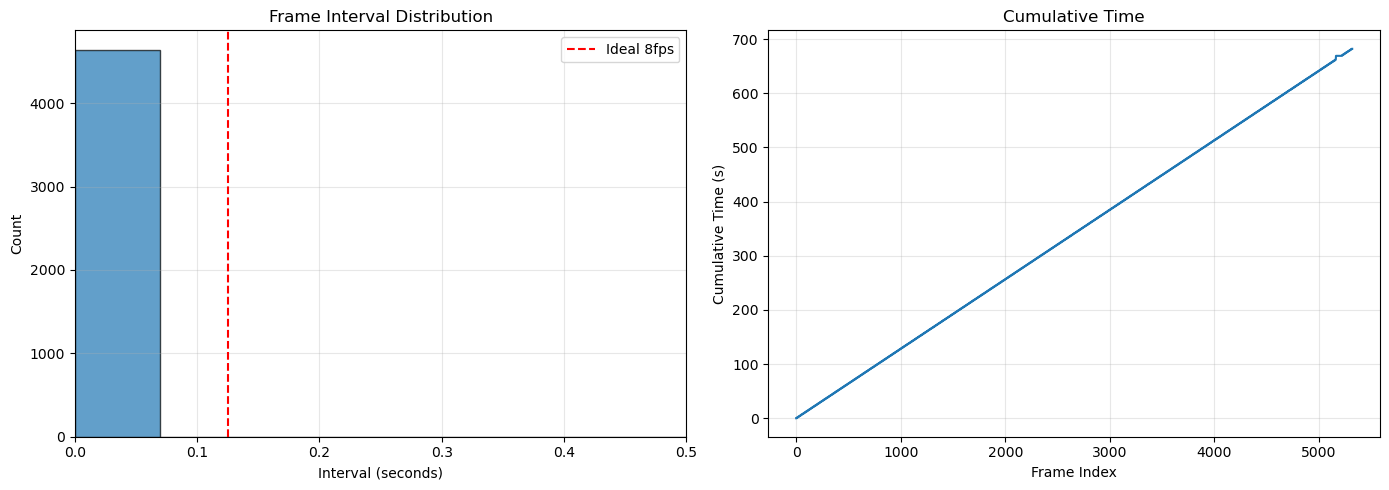

In [6]:
def analyze_thermal(thermal_data):
    timestamps = [d['timestamp'] for d in thermal_data]
    intervals = []
    for i in range(1, len(timestamps)):
        delta = (timestamps[i] - timestamps[i-1]).total_seconds()
        intervals.append(delta)
    intervals = np.array(intervals)
    
    print("\n" + "="*70)
    print("Thermal Data Analysis")
    print("="*70)
    print(f"Mean interval: {np.mean(intervals):.4f}s")
    print(f"Min: {np.min(intervals):.6f}s")
    print(f"Max: {np.max(intervals):.4f}s")
    print(f"Std: {np.std(intervals):.4f}s")
    
    burst_count = len(np.where(intervals < 0.01)[0])
    dropout_count = len(np.where(intervals > 0.5)[0])
    print(f"\nBurst (< 10ms): {burst_count}")
    print(f"Dropout (> 500ms): {dropout_count}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(intervals, bins=100, edgecolor='black', alpha=0.7)
    axes[0].axvline(0.125, color='r', linestyle='--', label='Ideal 8fps')
    axes[0].set_xlabel('Interval (seconds)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Frame Interval Distribution')
    axes[0].set_xlim(0, 0.5)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    cumulative = np.cumsum([0] + list(intervals))
    axes[1].plot(cumulative)
    axes[1].set_xlabel('Frame Index')
    axes[1].set_ylabel('Cumulative Time (s)')
    axes[1].set_title('Cumulative Time')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ROBUST_DIR / 'thermal_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return intervals, burst_count, dropout_count

intervals, burst_count, dropout_count = analyze_thermal(therm_data)

In [7]:
def clean_thermal(thermal_data, min_interval=0.05):
    print(f"\nCleaning thermal data...")
    print(f"Original: {len(thermal_data)} frames")
    
    thermal_sorted = sorted(thermal_data, key=lambda x: x['timestamp'])
    cleaned = [thermal_sorted[0]]
    
    for i in range(1, len(thermal_sorted)):
        current = thermal_sorted[i]
        last = cleaned[-1]
        time_diff = (current['timestamp'] - last['timestamp']).total_seconds()
        if time_diff >= min_interval:
            cleaned.append(current)
    
    print(f"After cleaning: {len(cleaned)} frames")
    print(f"Removed: {len(thermal_data) - len(cleaned)} burst frames")
    return cleaned

therm_data_clean = clean_thermal(therm_data)


Cleaning thermal data...
Original: 5318 frames
After cleaning: 677 frames
Removed: 4641 burst frames


In [8]:
def smart_pairing(thermal_data_clean, camera_start_time, fps, frame_count):
    pairs = []
    mismatches = {'before_start': 0, 'after_end': 0}
    
    print(f"\nSmart Pairing:")
    print(f"Thermal: {len(thermal_data_clean)} frames")
    print(f"RGB: {frame_count} frames @ {fps:.2f}fps")
    
    rgb_end_time = camera_start_time + timedelta(seconds=frame_count/fps)
    
    for idx, thermal_frame in enumerate(tqdm(thermal_data_clean, desc="Pairing")):
        thermal_ts = thermal_frame['timestamp']
        
        if thermal_ts < camera_start_time:
            mismatches['before_start'] += 1
            continue
        if thermal_ts > rgb_end_time:
            mismatches['after_end'] += 1
            continue
        
        offset = (thermal_ts - camera_start_time).total_seconds()
        rgb_frame_idx = int(round(offset * fps))
        rgb_frame_idx = max(0, min(rgb_frame_idx, frame_count - 1))
        
        actual_time = rgb_frame_idx / fps
        error = abs(actual_time - offset)
        
        pairs.append({
            'pair_id': f'pair_{len(pairs):05d}',
            'thermal': thermal_frame,
            'rgb_frame_idx': rgb_frame_idx,
            'timestamp': thermal_ts,
            'thermal_error': 0,
            'rgb_error': error
        })
    
    print(f"\nResults:")
    print(f"Successful pairs: {len(pairs)}")
    print(f"Success rate: {len(pairs) / len(thermal_data_clean) * 100:.1f}%")
    print(f"Before RGB start: {mismatches['before_start']}")
    print(f"After RGB end: {mismatches['after_end']}")
    
    if len(pairs) > 0:
        rgb_errors = [p['rgb_error'] * 1000 for p in pairs]
        print(f"\nRGB Error:")
        print(f"Mean: {np.mean(rgb_errors):.2f}ms")
        print(f"Max: {np.max(rgb_errors):.2f}ms")
    
    return pairs

pairs_new = smart_pairing(therm_data_clean, camera_start_time, fps, frame_count)


Smart Pairing:
Thermal: 677 frames
RGB: 16284 frames @ 24.67fps


Pairing: 100%|██████████| 677/677 [00:00<00:00, 367198.22it/s]


Results:
Successful pairs: 659
Success rate: 97.3%
Before RGB start: 0
After RGB end: 18

RGB Error:
Mean: 10.10ms
Max: 20.20ms


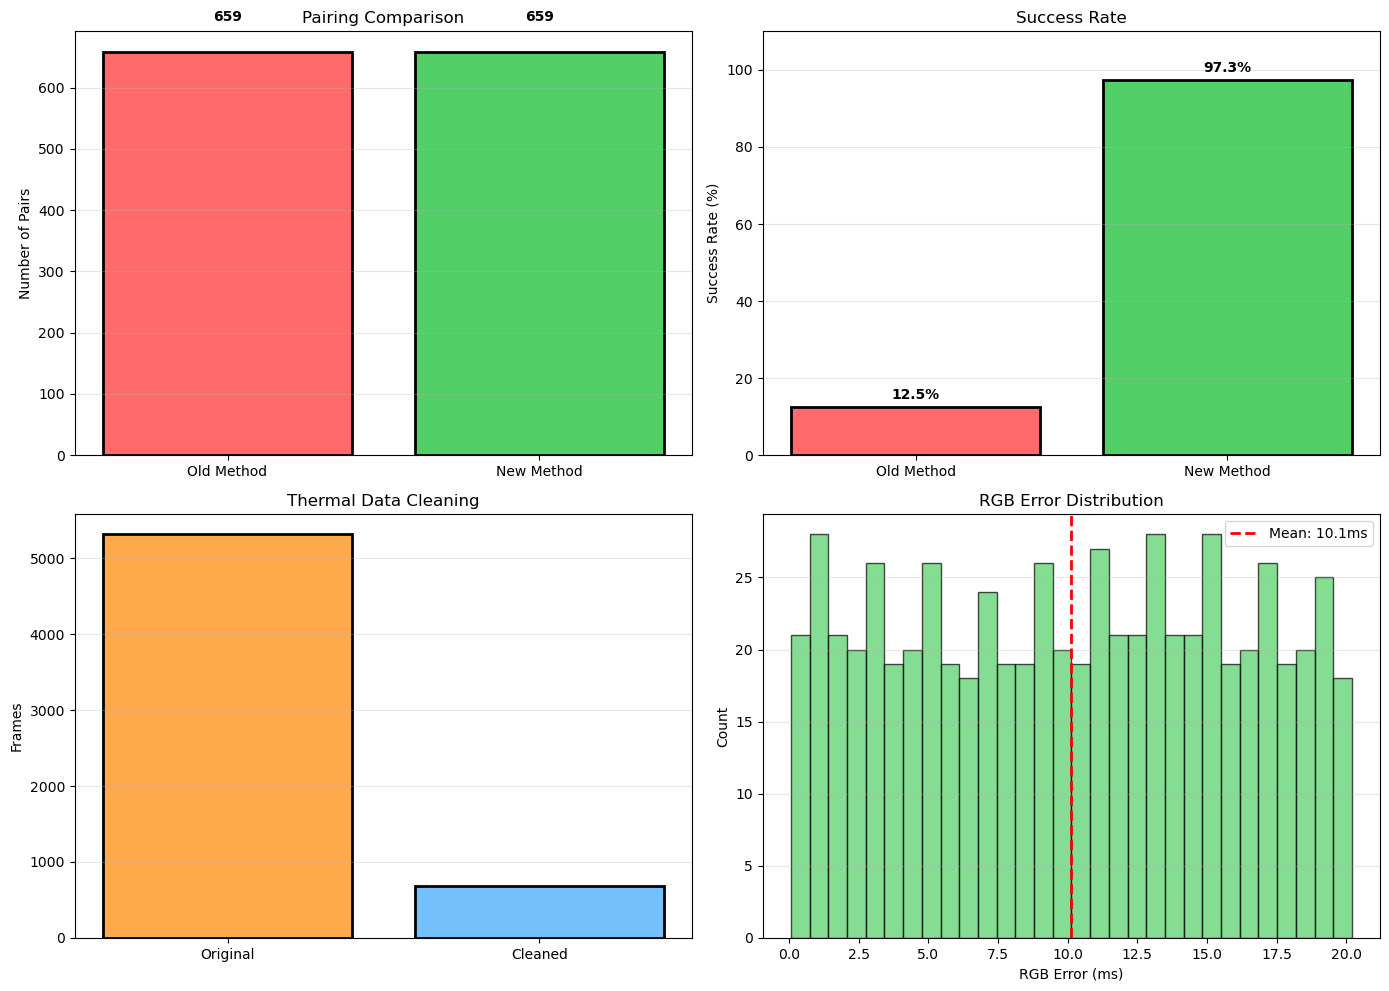

Comparison plot saved


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

old_count = 659
new_count = len(pairs_new)

methods = ['Old Method', 'New Method']
pair_counts = [old_count, new_count]
colors = ['#ff6b6b', '#51cf66']

axes[0, 0].bar(methods, pair_counts, color=colors, edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Number of Pairs')
axes[0, 0].set_title('Pairing Comparison')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, count in enumerate(pair_counts):
    axes[0, 0].text(i, count + 50, str(count), ha='center', fontweight='bold')

old_rate = old_count / 5271 * 100
new_rate = new_count / len(therm_data_clean) * 100
rates = [old_rate, new_rate]

axes[0, 1].bar(methods, rates, color=colors, edgecolor='black', linewidth=2)
axes[0, 1].set_ylabel('Success Rate (%)')
axes[0, 1].set_title('Success Rate')
axes[0, 1].set_ylim(0, 110)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, rate in enumerate(rates):
    axes[0, 1].text(i, rate + 2, f'{rate:.1f}%', ha='center', fontweight='bold')

thermal_sources = ['Original', 'Cleaned']
thermal_counts = [len(therm_data), len(therm_data_clean)]
axes[1, 0].bar(thermal_sources, thermal_counts, color=['#ffa94d', '#74c0fc'], edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('Frames')
axes[1, 0].set_title('Thermal Data Cleaning')
axes[1, 0].grid(axis='y', alpha=0.3)

if len(pairs_new) > 0:
    rgb_errors = [p['rgb_error'] * 1000 for p in pairs_new]
    axes[1, 1].hist(rgb_errors, bins=30, color='#51cf66', edgecolor='black', alpha=0.7)
    mean_err = np.mean(rgb_errors)
    axes[1, 1].axvline(mean_err, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_err:.1f}ms')
    axes[1, 1].set_xlabel('RGB Error (ms)')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('RGB Error Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(ROBUST_DIR / 'pairing_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Comparison plot saved")

In [10]:
print("\n" + "="*70)
print("Final Summary")
print("="*70)

print(f"\nProblems Found:")
print(f"  Burst frames (< 10ms): {burst_count}")
print(f"  Dropout (> 500ms): {dropout_count}")

print(f"\nOld Method:")
print(f"  Pairs: {old_count}")
print(f"  Success rate: {old_rate:.1f}%")
print(f"  Issue: Fixed 8fps timeline")

print(f"\nNew Method:")
print(f"  Pairs: {new_count}")
print(f"  Success rate: {new_rate:.1f}%")
print(f"  Improvement: +{new_count - old_count} pairs")

if new_count > old_count * 1.5:
    print(f"\n✓ New method is MUCH better!")
elif new_count > old_count:
    print(f"\n✓ New method is better")
else:
    print(f"\n⚠ Need further investigation")

print("\n" + "="*70)


Final Summary

Problems Found:
  Burst frames (< 10ms): 4641
  Dropout (> 500ms): 676

Old Method:
  Pairs: 659
  Success rate: 12.5%
  Issue: Fixed 8fps timeline

New Method:
  Pairs: 659
  Success rate: 97.3%
  Improvement: +0 pairs

⚠ Need further investigation

